In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stat

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, auc
import scikitplot as skplt

%matplotlib inline

sns.set_style('whitegrid')
sns.set_palette("Set1", n_colors=8, desat=.5)
# current_palette = sns.color_palette("Set1", n_colors=8, desat=.5)
# sns.palplot(current_palette)

In [2]:
fraud = pd.read_csv('./Fraud_Data.csv')
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
ip = pd.read_csv('./IpAddress_to_Country.csv')
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
x = fraud.ip_address[0]
ip[(ip.lower_bound_ip_address <= x) & (ip.upper_bound_ip_address >= x)].country.reset_index(drop = True)

0    Japan
Name: country, dtype: object

In [5]:
import time
start = time.time()
fraud['country'] = fraud.ip_address.apply(lambda x: ip[(ip.lower_bound_ip_address <= x) & (ip.upper_bound_ip_address >= x)].country.reset_index(drop = True))
print(time.time() - start)
fraud.head()

311.84925293922424


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [20]:
fraud['country'] = fraud.country.fillna('Unknown')

In [15]:
fraud['signup_time'] = pd.to_datetime(fraud.signup_time)
fraud['purchase_time'] = pd.to_datetime(fraud.purchase_time)
fraud['time_length'] = (fraud.purchase_time - fraud.signup_time).dt.seconds

In [13]:
ip_counts = fraud.ip_address.value_counts()
fraud['ip_shared'] = fraud.ip_address.map(ip_counts)

In [17]:
device_counts = fraud.device_id.value_counts()
fraud['device_shared'] = fraud.device_id.map(device_counts)

In [22]:
country_counts = fraud.country.value_counts()
fraud['country_shared'] = fraud.country.map(country_counts)

In [25]:
country_avg = fraud.groupby('country')['class'].mean()
fraud['average_country'] = fraud.country.map(country_avg)
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_length,ip_shared,device_shared,country_shared,average_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,7306,0.097865
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,58049,0.095626
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,58049,0.095626
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown,60085,1,1,21966,0.085723
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,58049,0.095626


In [27]:
df = fraud.drop(['user_id','signup_time','purchase_time','device_id','ip_address'], axis = 1)
df.head()

,purchase_value,source,browser,sex,age,class,country,time_length,ip_shared,device_shared,country_shared,average_country
0,34,SEO,Chrome,M,39,0,Japan,13882,1,1,7306,0.097865
1,16,Ads,Chrome,F,53,0,United States,17944,1,1,58049,0.095626
2,15,SEO,Opera,M,53,1,United States,1,12,12,58049,0.095626
3,44,SEO,Safari,M,41,0,Unknown,60085,1,1,21966,0.085723
4,39,Ads,Safari,M,45,0,United States,41461,1,1,58049,0.095626


In [28]:
df.isnull().sum()

purchase_value     0
source             0
browser            0
sex                0
age                0
class              0
country            0
time_length        0
ip_shared          0
device_shared      0
country_shared     0
average_country    0
dtype: int64

In [15]:
### KNN feature engineering

In [17]:
# data = pd.get_dummies(df.drop('average_by_country', axis = 1), drop_first = True)

# for col in ['purchase_value','age','time_length']:
#     m = data[col].mean()
#     sd = data[col].std()
#     data[col] = data[col].apply(lambda x: (x-m) / sd)
# knn = KNeighborsClassifier(n_neighbors=7, metric = 'manhattan', p = 1)
# knn.fit(X = data.drop('class', axis = 1), y = data['class'])

# start = time.time()
# knn_feature = knn.predict_proba(data.drop('class', axis = 1))
# print(time.time() - start)
# df['knn'] = knn_feature[:,1]

,purchase_value,age,class,time_length,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,-0.160204,0.679912,0,-0.127547,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.142588,2.304469,0,-1.566313,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,-1.197165,2.304469,1,-1.566313,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,0.385566,0.911991,0,-1.427970,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.112681,1.376150,0,-0.182884,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [29]:
X = pd.get_dummies(df.drop('class', axis = 1), drop_first = True)
y = df['class']

In [30]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 1066)

In [31]:
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
ypred = lr.predict(Xtest)

print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97     27413
          1       0.93      0.51      0.65      2810

avg / total       0.95      0.95      0.94     30223



In [33]:
print(confusion_matrix(ytest, ypred))

[[27300   113]
 [ 1388  1422]]


In [34]:
rf = RandomForestClassifier(n_estimators = 500)

rf.fit(Xtrain, ytrain)

ypred = rf.predict(Xtest)

print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     27413
          1       0.97      0.53      0.68      2810

avg / total       0.96      0.95      0.95     30223



In [ ]:
#              Confusion Matrix
#
#                  Predicted
#                  0   |    1
#          --|---------|----------|
#          0 |    TN   |    FP    |
# Actual   --|---------|----------|
#          1 |    FN   |    TP    |
#          --|---------|----------|
#
# Recall = TP / (TP+FN)
# Precision = TP / (TP+FP)

In [35]:
print(confusion_matrix(ytest, ypred))

[[27362    51]
 [ 1322  1488]]


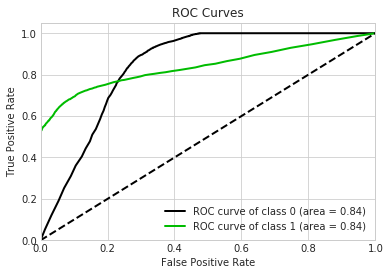

In [38]:
y_true = ytest
y_probas = rf.predict_proba(Xtest)
skplt.metrics.plot_roc_curve(y_true, y_probas, curves = 'each_class')
plt.show()

In [36]:
import xgboost as xgb

start = time.time()

dtrain = xgb.DMatrix(Xtrain, ytrain)
dvalid  = xgb.DMatrix(Xtest,  ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params = {
    'eta': 0.1,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'silent': 1
}
model = xgb.train(params, dtrain, 400, watchlist, verbose_eval=50, early_stopping_rounds=30)

ypred = model.predict(xgb.DMatrix(Xtest), ntree_limit=model.best_ntree_limit)
ypred = [1 if i > 0.5 else 0 for i in ypred]
print(classification_report(ytest, ypred))

[0]	train-logloss:0.612674	valid-logloss:0.613037
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 30 rounds.
[50]	train-logloss:0.152469	valid-logloss:0.161143
Stopping. Best iteration:
[57]	train-logloss:0.151347	valid-logloss:0.160974

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     27413
          1       1.00      0.52      0.69      2810

avg / total       0.96      0.96      0.95     30223



In [37]:
print(confusion_matrix(ytest, ypred))

[[27409     4]
 [ 1341  1469]]


In [60]:
ypred = model.predict(xgb.DMatrix(Xtest), ntree_limit=model.best_ntree_limit)
ypred = [1 if i > 0.6 else 0 for i in ypred]
print(classification_report(ytest, ypred))
print(confusion_matrix(ytest, ypred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     27413
          1       0.88      0.53      0.66      2810

avg / total       0.95      0.95      0.94     30223

[[27209   204]
 [ 1332  1478]]
